In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from model.drone_model_jax import get_default_params, pack_params, IDX
from utils.swarm_utils import assemble_swarm, swarm_evalf, swarm_compute_jacobian_jax

def get_simulation_setup():
    p = get_default_params()
    p_tuple = pack_params(p)
    targets = [(1.0, 1.0)]
    X0_flat, U = assemble_swarm(targets)
    return X0_flat, p_tuple, U

def step_euler(x, dt, p_tuple, U):
    dxdt = swarm_evalf(x, p_tuple, U)
    return x + dxdt * dt

def step_rk4(x, dt, p_tuple, U):
    k1 = swarm_evalf(x, p_tuple, U)
    k2 = swarm_evalf(x + 0.5 * dt * k1, p_tuple, U)
    k3 = swarm_evalf(x + 0.5 * dt * k2, p_tuple, U)
    k4 = swarm_evalf(x + dt * k3, p_tuple, U)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def step_trap(x, dt, p_tuple, U):
    tol = 1e-10
    max_iter = 100
    I = np.eye(len(x))
    
    f_curr = swarm_evalf(x, p_tuple, U)
    x_next = x + f_curr * dt
    
    for _ in range(max_iter):
        f_next = swarm_evalf(x_next, p_tuple, U)
        residual = x_next - x - (dt / 2.0) * (f_curr + f_next)
        
        if np.linalg.norm(residual) < tol:
            break
            
        J_f = swarm_compute_jacobian_jax(x_next, p_tuple, U)
        if np.isnan(J_f).sum() > 0:
            break
            
        J_G = I - (dt / 2.0) * J_f
        delta = np.linalg.solve(J_G, -residual)
        x_next += delta
        
    return x_next

def run_simulation(step_fn, x0, dt, T_final, p_tuple, U):
    X = [x0.copy()]
    T = [0]
    x = x0.copy()
    steps = int(T_final / dt)
    for i in range(steps):
        x = step_fn(x, dt, p_tuple, U)
        X.append(x)
        T.append((i+1)*dt)
    return x, np.array(X), np.array(T)

X0, p_tuple, U = get_simulation_setup()
T_final = 1.0

dt_ref = 1e-4
x_ref, X_ref, T_ref = run_simulation(step_rk4, X0, dt_ref, T_final, p_tuple, U)

In [11]:
dts = np.arange(1e-3, 3.01e-2, 2e-3)
methods = {
    'Euler': step_euler,
    'Trapezoidal': step_trap,
    'RK4': step_rk4
}

errors = {name: [] for name in methods}
for dt in tqdm(dts):
    for name, func in methods.items():
        x_final, _, _ = run_simulation(func, X0, dt, T_final, p_tuple, U)
        error = np.max(np.abs(x_final - x_ref))
        errors[name].append(error)

100%|███████████████████████████████| 15/15 [00:09<00:00,  1.61it/s]


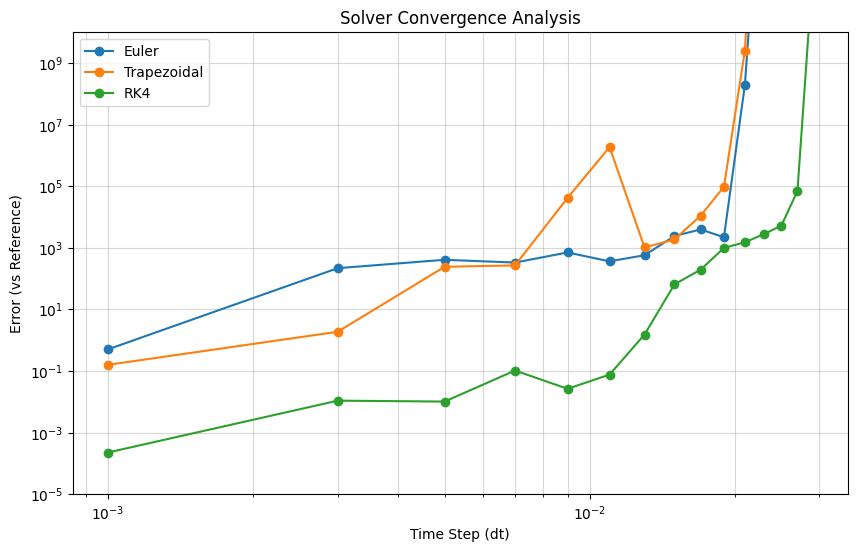

In [53]:
plt.figure(figsize=(10, 6))
for name, err_list in errors.items():
    plt.plot(dts, err_list, 'o-', label=name)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5, 1e10])
plt.xlabel('Time Step (dt)')
plt.ylabel('Error (vs Reference)')
plt.title('Solver Convergence Analysis')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

# Dynamic

In [50]:
def get_ref_state(t, T_ref, X_ref):
    dt = T_ref[1] - T_ref[0]
    
    # find index
    idx = int(t / dt)
    
    # edge case
    if idx >= len(T_ref) - 1:
        return X_ref[-1]
    
    # interpolation
    t_low = T_ref[idx]
    alpha = (t - t_low) / dt
    
    x_interp = (1 - alpha) * X_ref[idx] + alpha * X_ref[idx+1]
    return x_interp

    
def run_dynamic_simulation(step_fn, x0, T_final, p_tuple, U, T_ref, X_ref, tol_error=0.1):
    x = x0.copy()
    t = 0.0
    dt = 1e-4
    dt_min = 1e-4
    dt_max = 1e-2
    
    history_dt = []
    while t < T_final:
        # 0. Adjust
        if t + dt > T_final:
            dt = T_final - t  # s.t., t+dt == T_final

        # 1. Step
        x_next_candidate = step_fn(x, dt, p_tuple, U)

        # 2. Get Ref
        x_true = get_ref_state(t + dt, T_ref, X_ref)
        
        # 3. Compute Error
        error = np.max(np.abs(x_next_candidate - x_true))
        
        # 4. Check against Tolerance (e_a)
        if error > tol_error:
            # REJECT: Error > tolerance
            if dt == dt_min:
                x = x_next_candidate
                t += dt
                history_dt.append(dt)
            else:
                dt -= 1e-3

                dt = max(dt, dt_min)
        else:
            # ACCEPT: Error <= tolerance
            x = x_next_candidate
            t += dt
            history_dt.append(dt)
            
            dt += 1e-3
            dt = min(dt, dt_max)
    return x, history_dt

In [51]:
x_final, history_dt = run_dynamic_simulation(step_rk4, X0, T_final, p_tuple, U, T_ref, X_ref, tol_error=1e-2)

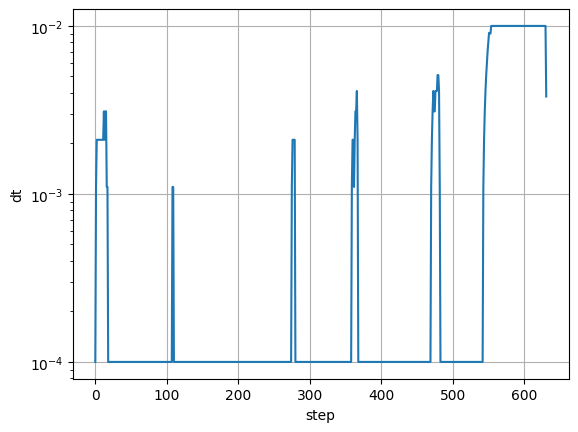

In [52]:
plt.figure()
plt.plot(history_dt)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('dt')
plt.grid()
plt.show()